In [1]:
## Multi class classification with Linear SVC

In [1]:
## (1) Loading requiredmodules :

import pandas as pd
import numpy as np
import scipy
import re
import os
from keras.preprocessing.text import Tokenizer

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
## (2) Loading Data - labelled data :

data_1 = pd.ExcelFile('R3_RNN_Tranzact_Rohan_1_Regrouped_with_supplier.xlsx')
tranzact_data_1 = data_1.parse(0)

## Loading Data - un-labelled data:

data_2 = pd.ExcelFile('14Mar_Gorky_one_labelled.xlsx')
tranzact_data_new_1 = data_2.parse(0)

## Picking up required info from labelled data :

col = ['to_company_name', 'supplier_item_id.2', 'product', 'supplier']
tranzact_data_2 = tranzact_data_1[col]
tranzact_data_2.columns = ['OEM', 'item', 'product', 'supplier']

## Picking up required info from un-labelled data:

col = ['from_company_name', 'buyer_item_name', 'product', 'to_company_name']
tranzact_data_new_2 = tranzact_data_new_1[col]
tranzact_data_new_2.columns = ['OEM', 'item', 'product', 'supplier']

# Creating separate dataframe for Cesare Bonetti International Pvt. Ltd. from labelled Dat:

tranzact_data_cesare_international_1 = tranzact_data_2.loc[tranzact_data_2['OEM'] \
                                                               == 'CESARE BONETTI INTERNATIONAL PVT. LTD.']
tranzact_data_2_revised = tranzact_data_2.drop(tranzact_data_cesare_international_1.index)
tranzact_data_cesare_international_1 = tranzact_data_cesare_international_1.reset_index(drop=True)
tranzact_data_2_revised = tranzact_data_2_revised.reset_index(drop=True)

# Creating separate dataframe for Cesare Bonetti International Pvt. Ltd. from unlabelled data :

tranzact_data_cesare_international_2 = tranzact_data_new_2.loc[tranzact_data_new_2['OEM'] \
                                                               == 'CESARE BONETTI INTERNATIONAL PVT. LTD.']
tranzact_data_new_2_revised = tranzact_data_new_2.drop(tranzact_data_cesare_international_2.index)
tranzact_data_cesare_international_2 = tranzact_data_cesare_international_2.reset_index(drop=True)
tranzact_data_new_2_revised = tranzact_data_new_2_revised.reset_index(drop=True)

# Removing all 'Bonetti' & 'Waaree' supplier from both labelled and un-labelled data :

## First make Items in lower case and remove rows with any cell value = none :

tranzact_data_2_revised['item'] = tranzact_data_2_revised['item'].map(lambda x: x if type(x)!=str else x.lower()) 
tranzact_data_2_revised['product'] = tranzact_data_2_revised['product'].map(lambda x: x if type(x)!=str else x.lower())
tranzact_data_2_revised['supplier'] = tranzact_data_2_revised['supplier'].map(lambda x: x if type(x)!=str else x.lower())
#tranzact_data_2_revised = tranzact_data_2_revised.dropna() ## remove rows with cell value none

tranzact_data_new_2_revised['item'] = tranzact_data_new_2_revised['item'].map(lambda x: x if type(x)!=str else x.lower())
tranzact_data_new_2_revised['product'] = tranzact_data_new_2_revised['product'].map(lambda x: x if type(x)!=str else x.lower())
tranzact_data_new_2_revised['supplier'] = tranzact_data_new_2_revised['supplier'].map(lambda x: x if type(x)!=str else x.lower())
#tranzact_data_new_2_revised = tranzact_data_new_2_revised.dropna() ## remove rows with cell value none

# Removing string 'bonetti' and 'waaree' from supplier :

supplier_bonetti_2 = tranzact_data_2_revised[tranzact_data_2_revised['supplier'].str.contains('bonetti')]
supplier_waaree_2 = tranzact_data_2_revised[tranzact_data_2_revised['supplier'].str.contains('waaree')]
supplier_bonetti_new_2 = tranzact_data_new_2_revised[tranzact_data_new_2_revised['supplier'].str.contains('bonetti')]
supplier_waaree_new_2 = tranzact_data_new_2_revised[tranzact_data_new_2_revised['supplier'].str.contains('waaree')]

tranzact_data_3 = tranzact_data_2_revised.drop(supplier_bonetti_2.index) # 'bonetti' removed
tranzact_data_3 = tranzact_data_3.drop(supplier_waaree_2.index)   # 'waaree' removed
tranzact_data_new_3 = tranzact_data_new_2_revised.drop(supplier_bonetti_new_2.index)
tranzact_data_new_3 = tranzact_data_new_3.drop(supplier_waaree_new_2.index)

tranzact_data_3 = tranzact_data_3.reset_index(drop=True)
tranzact_data_new_3 = tranzact_data_new_3.reset_index(drop=True)

# Merging two data frames :

tranzact_data_combined = pd.concat([tranzact_data_3, tranzact_data_new_3], axis=0, ignore_index=True)

# Removing duplicate (item + supplier) combinations :

tranzact_data_combined['find_duplicate'] = tranzact_data_combined['item'].map(str) + \
                                            tranzact_data_combined['supplier'].map(str)

tranzact_data_combined.drop_duplicates(subset='find_duplicate', keep = 'first', inplace = True)
tranzact_data_combined = tranzact_data_combined.reset_index(drop=True)


In [3]:
## (3) cleaning the data :

pd.options.mode.chained_assignment = None

## Join all hyphaned words :

tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'([a-z])-([a-z])', r'\1\2')
tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'([0-9])-([a-z])', r'\1\2')

## Removing underscores '_':

under_score = ['_']

for i in under_score:
    
    tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(i," ")    ## remove underscores

tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'\W',' ')   ## remove puntuations

## joinning consecutive single letters - SS:

s_s_list = pd.DataFrame()
s_s_list['item'] = tranzact_data_combined['item'].str.findall(r'(?i)\b[s]\s+\b[s]\b')    
s_s_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'(?i)\b[s]\s+\b[s]\b')].index.values
s_s_list = s_s_list[s_s_list.astype(str)['item'] != '[]']
s_s_list['joined'] = s_s_list.item.apply(''.join)
s_s_list.joined = s_s_list.joined.str.replace(' ', '')

## joinning consecutive single letters - MS:

ms_list = pd.DataFrame()
ms_list['item'] = tranzact_data_combined['item'].str.findall(r'(?i)\b[m]\s+\b[s]\b')    
ms_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'(?i)\b[m]\s+\b[s]\b')].index.values
ms_list = ms_list[ms_list.astype(str)['item'] != '[]']
ms_list['joined'] = ms_list.item.apply(''.join)
ms_list.joined = ms_list.joined.str.replace(' ', '')

## joinning consecutive single letters - CI:

ci_list = pd.DataFrame()
ci_list['item'] = tranzact_data_combined['item'].str.findall(r'(?i)\b[c]\s+\b[i]\b')    
ci_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'(?i)\b[c]\s+\b[i]\b')].index.values
ci_list = ci_list[ci_list.astype(str)['item'] != '[]']
ci_list['joined'] = ci_list.item.apply(''.join)
ci_list.joined = ci_list.joined.str.replace(' ', '')

## joinning consecutive single letters - CS:

cs_list = pd.DataFrame()
cs_list['item'] = tranzact_data_combined['item'].str.findall(r'(?i)\b[c]\s+\b[s]\b')    
cs_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'(?i)\b[c]\s+\b[s]\b')].index.values
cs_list = cs_list[cs_list.astype(str)['item'] != '[]']
cs_list['joined'] = cs_list.item.apply(''.join)
cs_list.joined = cs_list.joined.str.replace(' ', '')

## substituting above cell in tranzact_data_combine :

for i in s_s_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'(?i)\b[s]\s+\b[s]\b', s_s_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in ms_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'(?i)\b[m]\s+\b[s]\b', ms_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in ci_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'(?i)\b[c]\s+\b[i]\b', ci_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in cs_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'(?i)\b[c]\s+\b[s]\b', cs_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]



In [4]:
## (4) cleaning data(continued):

# making list for joinning is with number(indian standards):
is_list = pd.DataFrame()
is_list['item'] = tranzact_data_combined['item'].str.findall(r'\b\is\s+\d+\b')
is_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\b\is\s+\d+\b')].index.values
is_list = is_list[is_list.astype(str)['item'] != '[]']
is_list['joined'] = is_list.item.apply(''.join)
is_list.joined = is_list.joined.str.replace(' ', '')

# making list for joinning en with number(en standards):
en_list = pd.DataFrame()
en_list['item'] = tranzact_data_combined['item'].str.findall(r'\b\en\s+\d+\b')
en_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\b\en\s+\d+\b')].index.values
en_list = en_list[en_list.astype(str)['item'] != '[]']
en_list['joined'] = en_list.item.apply(''.join)
en_list.joined = en_list.joined.str.replace(' ', '')
2,
# making list for joinning ss with number(ss standards):
ss_list = pd.DataFrame()
ss_list['item'] = tranzact_data_combined['item'].str.findall(r'\bs\w\s+\d{2,3}\b')
ss_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\bs\w\s+\d{2,3}\b')].index.values
ss_list = ss_list[ss_list.astype(str)['item'] != '[]']
ss_list['joined'] = ss_list.item.apply(''.join)
ss_list.joined = ss_list.joined.str.replace(' ', '')

# making list for joinning fg with number(casting standards):
fg_list = pd.DataFrame()
fg_list['item'] = tranzact_data_combined['item'].str.findall(r'\b[f]\g\s+\d+\b')
fg_list_index = tranzact_data_combined[tranzact_data_combined['item'].str.contains(r'\b[f]\g\s+\d+\b')].index.values
fg_list = fg_list[fg_list.astype(str)['item'] != '[]']
fg_list['joined'] = fg_list.item.apply(''.join)
fg_list.joined = fg_list.joined.str.replace(' ', '')

## substituting above in tranzact_data_combine :

for i in is_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'\b\is\s+\d+\b', is_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in en_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'\b\en\s+\d+\b', en_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in ss_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'\bs\w\s+\d{2,3}\b', ss_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]
    
for i in fg_list_index:    
    [tranzact_data_combined['item'][i]] = [re.sub(r'\b[f]\g\s+\d+\b', fg_list['joined'][i], a) \
                                           for a in [tranzact_data_combined['item'][i]]]

## Remove dimensions alongwith units(mm etc) and lastly integers :

tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\d+x\d+x\d+\w*\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\d+x\d+\w*\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\d+\w*\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\bx\w+\b',' ')

tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\id\s*\d+\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\od\s*\d+\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\bd\ia\s*\d+\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\bd\s*\d+\b',' ')

## Remove m8 etc. :

tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'\b\m\d+\b',' ')
tranzact_data_combined['item']= tranzact_data_combined['item'].str.replace(r'\b\m\d+x\w+\b',' ')

## Breaking some words like 'perforatedsheet' etc.:

tranzact_data_combined['item'] = tranzact_data_combined['item'].str.replace(r'\b\perforatedsheet\b','perforated sheet')


## Remove bad words as per list below :
, 
bad_ist = ['mm', 'inch', 'ft', 'feet', 'mtr', 'volt', 'amp', 'micron', 'microns', 'swg', 'cfm', 'kg', \
           'tons', 'mfd', 'ah', 'id', 'od', 'dia', 'to', 'for', 'x']

tranzact_data_combined['item']= tranzact_data_combined['item'].apply(lambda x:' '.join([i for i in x.split()
                                                                                if i not in bad_ist]).lower())



tranzact_data_combined = tranzact_data_combined.reset_index(drop=True)

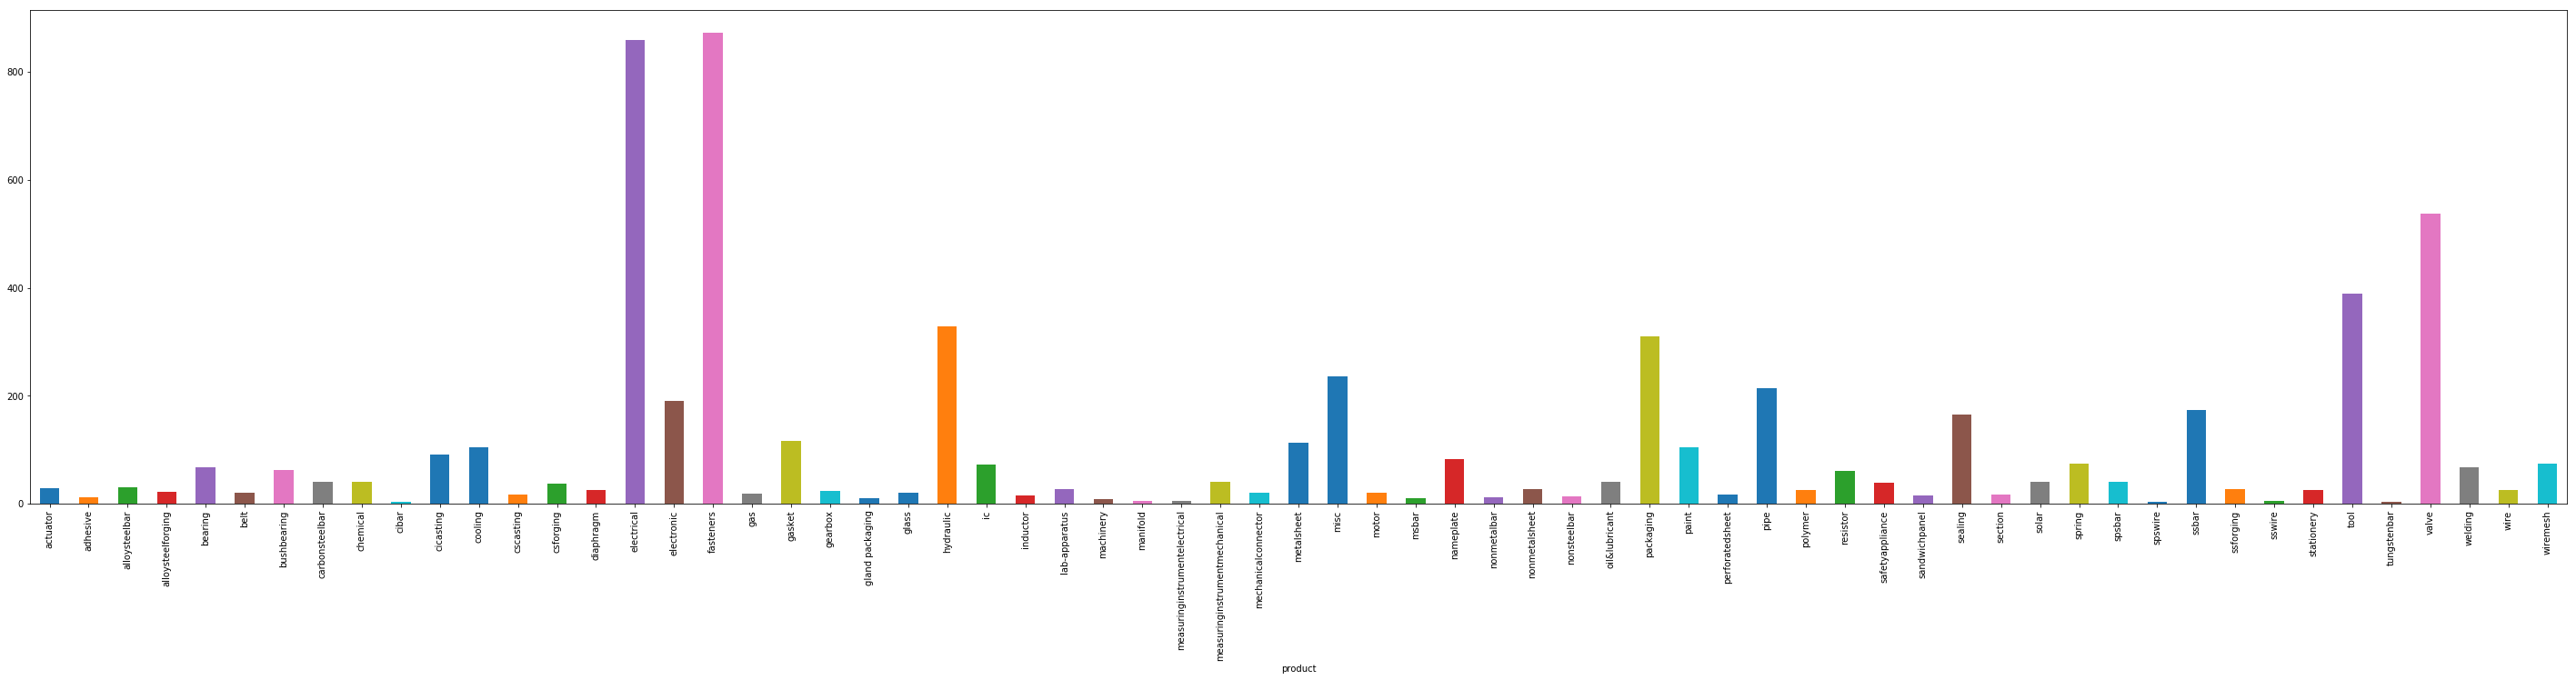

In [5]:
# (5) Splitting data into labelled and unlabelled :

tranzact_data_labelled = pd.DataFrame()
tranzact_data_unlabelled = pd.DataFrame()

tranzact_data_labelled = tranzact_data_combined[tranzact_data_combined['product'].notnull()]
tranzact_data_labelled = tranzact_data_labelled.dropna() ## remove any other rows with cell value none
tranzact_data_unlabelled = tranzact_data_combined.drop(tranzact_data_labelled.index)

tranzact_data_labelled.drop_duplicates(subset='item', keep = 'first', inplace = True) # remove duplicate items

tranzact_data_labelled = tranzact_data_labelled.reset_index(drop=True)
tranzact_data_unlabelled = tranzact_data_unlabelled.reset_index(drop=True)

# digitising 'product' and creating a dictionary :

tranzact_data_labelled['product_id'] = tranzact_data_labelled['product'].factorize()[0]

product_id_df = tranzact_data_labelled[['product', 'product_id']].drop_duplicates().sort_values('product_id')
product_to_id = dict(product_id_df.values)
id_to_product = dict(product_id_df[['product_id', 'product']].values)

## To show distribution of product category

fig = plt.figure(figsize=(50,10))
# print(max(tranzact_data_labelled.groupby('product').item.count()))
tranzact_data_labelled.groupby('product').item.count().plot.bar(ylim=0)
plt.show()


In [6]:
## (6) Gives the product wise item distribution. Data needs to be judiciously balanced in future.
from collections import Counter
Counter(tranzact_data_labelled["product"])

Counter({'actuator': 29,
         'adhesive': 12,
         'alloysteelbar': 31,
         'alloysteelforging': 23,
         'bearing': 67,
         'belt': 21,
         'bushbearing': 62,
         'carbonsteelbar': 41,
         'chemical': 41,
         'cibar': 4,
         'cicasting': 91,
         'cooling': 104,
         'cscasting': 17,
         'csforging': 37,
         'diaphragm': 26,
         'electrical': 859,
         'electronic': 191,
         'fasteners': 872,
         'gas': 19,
         'gasket': 116,
         'gearbox': 24,
         'gland packaging': 10,
         'glass': 21,
         'hydraulic': 328,
         'ic': 73,
         'inductor': 16,
         'lab-apparatus': 28,
         'machinery': 9,
         'manifold': 6,
         'measuringinstrumentelectrical': 6,
         'measuringinstrumentmechanical': 40,
         'mechanicalconnector': 20,
         'metalsheet': 113,
         'misc': 236,
         'motor': 21,
         'msbar': 11,
         'nameplate': 82,
     

In [7]:
## (7) Creating X and y variables for training. X = Items and y = 'product' or product category

X = []
for i in range(tranzact_data_labelled.shape[0]):
    X.append(tranzact_data_labelled.iloc[i][1])
y = np.array(tranzact_data_labelled["product"])

#train test split in 80% / 20% ratio

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=5)

## Creating the pipeline for learning which include vectorizing and training with 
## Support Vector Classifier with Linear Kernel :

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier


model = Pipeline([('vectorizer', CountVectorizer(ngram_range=(1,2))), \
                  ('tfidf', TfidfTransformer(norm='l2', use_idf=True)), \
                  ('clf', OneVsRestClassifier(LinearSVC(C=1, class_weight = 'balanced')))])

#fit model with training data

model.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('vectorizer', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None, stop_words=None,
       ...lti_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0),
          n_jobs=1))])

In [8]:
## (8) Input Item name here in the syntax given below :

Search_Item = 'hdpe welding rod'

Input_Item_Name = [Search_Item]

## To decide a valid item

tokenizer_obj_labelled = Tokenizer()
tokenizer_obj_labelled.fit_on_texts(tranzact_data_labelled['item'])
Input_tokens = tokenizer_obj_labelled.texts_to_sequences(Input_Item_Name)

def cos_cdist(matrix, vector):
    v = vector.reshape(1, -1)
    return scipy.spatial.distance.cdist(matrix, v, 'cosine').reshape(-1)

result_frame = []
result_frame = pd.DataFrame()
if len(Input_tokens[0]) == 0:
    print('There are no such items in our data base')
else:
    print("\033[4mName of suppliers\033[0m :")
    Output_Product_Category = model.predict(Input_Item_Name)
    output_cat_list = Output_Product_Category.tolist()
    
    
    tranzact_data_search = tranzact_data_labelled.loc[tranzact_data_labelled['product'] == output_cat_list[0]] 
                                                               
    tranzact_data_search = tranzact_data_search.reset_index(drop=True)

    my_vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=1, norm='l2', ngram_range=(1, 2), use_idf = True)
    
    merge_text_feature = []
    merge_text_feature_digit = []
    merge_digit_vector = []
    test_digit_vector = []

    merge_text_feature = tranzact_data_search['item'].append(pd.Series(Input_Item_Name))
    merge_text_feature = merge_text_feature.reset_index(drop=True)
    merge_text_feature_digit = my_vectorizer.fit(merge_text_feature)

# encode document
    merge_digit_vector = merge_text_feature_digit.transform(merge_text_feature).toarray()
    test_digit_vector = merge_digit_vector[len(merge_digit_vector)-1].reshape((merge_digit_vector.shape)[1],)
    merge_digit_vector_1 = merge_digit_vector[0:(len(merge_digit_vector)-1)]
## Finding cosine similarity & picking 50 top similar lines :

    c_d = []
    c_d = np.round((1 - cos_cdist(merge_digit_vector_1, test_digit_vector)), 3)
    max_c_s_index = []
    max_c_s_index = np.argsort(c_d)[-50:][::-1]

    result = []
    result_frame = []
    max_c_s_index = []
    max_c_s_index = np.argsort(c_d)[-50:][::-1]

    for i in max_c_s_index:
    
        result.append(np.array([c_d[i], tranzact_data_search['item'][i], tranzact_data_search['supplier'][i]]))

    result_frame = pd.DataFrame(result, columns=['similarity_index', 'item', 'supplier'])

    result_frame.similarity_index = result_frame.similarity_index.astype('float64')

    result_frame.drop_duplicates(subset='supplier', keep = 'first', inplace = True)
    result_frame = result_frame.reset_index(drop=True)

    kount = 0

    for i in range(len(result_frame['supplier'])):
        if result_frame['similarity_index'][i] >0:
            print(result_frame['supplier'][i])
            kount = kount+1
            if kount == 4 :
                break
result_frame.head(10)


Name of suppliers :
advance trading company
bansal wire industries ltd.
yeshwant wires pvt ltd
shield mac industries


,similarity_index,item,supplier
0,1.000,hdpe welding rod,advance trading company
1,0.297,consumables welding rod,bansal wire industries ltd.
2,0.286,stellite welding rod,yeshwant wires pvt ltd
3,0.277,welding rod pack,shield mac industries
4,0.277,aluminium welding rod,vividh wires limited
5,0.183,ss welding rod wolfarm make,m.v enterprises
6,0.088,brazing rod,mathure metal works pvt ltd
7,0.070,welding sleeve,m/s. s. k. enterprise
8,0.066,er tig filler rod,mesta inc
9,0.062,er410 tig filler rod,maxell forge industries


In [9]:
len(X)

6259

In [10]:
X_digit = my_vectorizer.fit(X)

X_vector = X_digit.transform(X).toarray()


In [11]:
X_vector.shape

(6259, 16492)

In [12]:
max(X_vector[6258])

0.47668067979514284

In [13]:
min(X_vector[6258])

0.0

In [14]:
from sklearn.cluster import DBSCAN

In [15]:
db = DBSCAN(eps = 1, min_samples = 3)
model = db.fit(X_vector)

In [16]:
labels = model.labels_

In [17]:
labels

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
len(labels)

6259

In [19]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters

8

In [20]:
n_clusters = len(set(labels))
n_clusters

9

In [21]:
db_1 = DBSCAN(eps = .5, min_samples = 3)
model_1 = db_1.fit(X_vector)

labels_1 = model_1.labels_

n_clusters_1 = len(set(labels_1)) - (1 if -1 in labels_1 else 0)
n_clusters_1

29

In [24]:
from sklearn import metrics
print('Silhouette Coefficient : %0.3f' % metrics.silhouette_score(X_vector, labels_1))

Silhouette Coefficient : -0.022


In [25]:
print('Silhouette Coefficient : %0.3f' % metrics.silhouette_score(X_vector, labels))

Silhouette Coefficient : -0.005


In [27]:
db_2 = DBSCAN(eps = .25, min_samples = 3)
model_2 = db_2.fit(X_vector)

labels_2 = model_2.labels_

n_clusters_2 = len(set(labels_2)) - (1 if -1 in labels_2 else 0)
print(n_clusters_2)

print('Silhouette Coefficient : %0.3f' % metrics.silhouette_score(X_vector, labels_2))

9
Silhouette Coefficient : -0.002


In [44]:
db_3 = DBSCAN(eps = 0.35, min_samples = 3)
model_3 = db_3.fit(X_vector)

labels_3 = model_3.labels_

n_clusters_3 = len(set(labels_3)) - (1 if -1 in labels_3 else 0)
print(n_clusters_3)

print('Silhouette Coefficient : %0.3f' % metrics.silhouette_score(X_vector, labels_3))

9
Silhouette Coefficient : -0.002


In [96]:
db_4 = DBSCAN(eps = .8, min_samples = 3)
model_4 = db_4.fit(X_vector)
labels_4 = model_4.labels_

n_clusters_4 = len(set(labels_4)) - (1 if -1 in labels_4 else 0)
print(n_clusters_4)

print('Silhouette Coefficient : %0.3f' % metrics.silhouette_score(X_vector, labels_4))

287
Silhouette Coefficient : 0.002


In [98]:
db_4 = DBSCAN(eps = .79, min_samples = 3)
model_4 = db_4.fit(X_vector)
labels_4 = model_4.labels_

n_clusters_4 = len(set(labels_4)) - (1 if -1 in labels_4 else 0)
print(n_clusters_4)

print('Silhouette Coefficient : %0.3f' % metrics.silhouette_score(X_vector, labels_4))

279
Silhouette Coefficient : -0.001


In [106]:
db_4 = DBSCAN(eps = 0.95, min_samples = 3)
model_4 = db_4.fit(X_vector)
labels_4 = model_4.labels_

n_clusters_4 = len(set(labels_4)) - (1 if -1 in labels_4 else 0)
print(n_clusters_4)

print('Silhouette Coefficient : %0.3f' % metrics.silhouette_score(X_vector, labels_4))

356
Silhouette Coefficient : 0.031


In [57]:
print(set(labels_3))
print(len(labels_3))
print(labels_3[2])
print(type(labels_3))
print(labels_3.shape)

{0, 1, 2, 3, 4, 5, 6, 7, 8, -1}
6259
-1
<class 'numpy.ndarray'>
(6259,)


In [ ]:
# Silhouette Score: The silhouette score is calculated utilizing the mean intra- cluster distance 
# between points, AND the mean nearest-cluster distance. For instance, a cluster with a lot of data 
# points very close to each other (high density) AND is far away from the next nearest cluster 
# (suggesting the cluster is very unique in comparison to the next closest), will have a strong 
# silhouette score. A silhouette score ranges from -1 to 1, with -1 being the worst score possible
# and 1 being the best score. Silhouette scores of 0 suggest overlapping clusters.

In [94]:
kounter = 0
for i in range(len(labels_4)):
    if labels_4[i] == -1:
        kounter = kounter + 1
print(kounter)

4777
